# Voice Command Inference Analysis

**Comprehensive analysis of inference accuracy, latency, and decision filter effectiveness**

- Accuracy metrics & confusion matrix
- Latency breakdown (inference → transport → ACK)
- Decision filter impact
- Threshold optimization recommendations

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import os
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (14, 6)

# Load data
log_file = 'inference_log_detailed.csv'

if not os.path.exists(log_file):
    print(f"⚠️  {log_file} not found. Run inference_gui.py first and collect some samples.")
    df = pd.DataFrame()  # Empty for now
else:
    # Read with error handling for inconsistent columns
    df = pd.read_csv(log_file, on_bad_lines='skip', engine='python')
    print(f"✅ Loaded {len(df)} records from {log_file}")
    print(f"\nColumns: {list(df.columns)}")
    
    # Handle both old format (9 columns) and new format (10 columns with ACK latency)
    if "Server ACK Latency (ms)" not in df.columns:
        print("⚠️  Old CSV format detected (no ACK Latency column)")
        print("   → Adding zero-filled ACK Latency column for compatibility")
        df.insert(df.columns.get_loc("Total Response Time (ms)"), "Server ACK Latency (ms)", 0.0)
        print(f"   → Updated columns: {list(df.columns)}")
    
    print(f"\nFirst 5 rows:")
    print(df.head())

✅ Loaded 102 records from inference_log_detailed.csv

Columns: ['ID Percobaan', 'Timestamp', 'Perintah Suara (Label - Manual)', 'Prediksi Model', 'Status (Benar/Salah - Manual)', 'Confidence', 'Inference Time (ms)', 'Transport Latency (ms)', 'Server ACK Latency (ms)', 'Total Response Time (ms)']

First 5 rows:
   ID Percobaan            Timestamp  Perintah Suara (Label - Manual)  \
0             1  2026-01-11 05:40:41                              NaN   
1             2  2026-01-11 05:40:45                              NaN   
2             3  2026-01-11 05:41:00                              NaN   
3             4  2026-01-11 05:41:04                              NaN   
4             5  2026-01-11 05:41:48                              NaN   

  Prediksi Model  Status (Benar/Salah - Manual)  Confidence  \
0             up                            NaN        0.90   
1      Uncertain                            NaN        0.46   
2      Uncertain                            NaN        0.51 

## 1. Data Overview

In [17]:
if len(df) > 0:
    print(f"Total predictions: {len(df)}")
    print(f"\nPrediction breakdown:")
    print(df['Prediksi Model'].value_counts())
    
    # Separate Uncertain vs Committed
    committed = df[df['Prediksi Model'] != 'Uncertain']
    uncertain = df[df['Prediksi Model'] == 'Uncertain']
    
    print(f"\n📊 Decision Summary:")
    print(f"  Committed: {len(committed)} ({len(committed)/len(df)*100:.1f}%)")
    print(f"  Uncertain: {len(uncertain)} ({len(uncertain)/len(df)*100:.1f}%)")
    
    # Show timestamp range
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    duration = (df['Timestamp'].max() - df['Timestamp'].min()).total_seconds()
    print(f"\n⏱️  Test duration: {duration:.1f} seconds")
else:
    print("No data yet. Collect samples first!")

Total predictions: 102

Prediction breakdown:
Prediksi Model
up           32
right        19
Uncertain    18
left         17
down         16
Name: count, dtype: int64

📊 Decision Summary:
  Committed: 84 (82.4%)
  Uncertain: 18 (17.6%)

⏱️  Test duration: 909.0 seconds


## 2. Latency Analysis

In [18]:
if len(committed) > 0:
    # Convert latency columns to numeric (handle any string values)
    latency_cols = ['Inference Time (ms)', 'Transport Latency (ms)', 'Server ACK Latency (ms)', 'Total Response Time (ms)']
    
    for col in latency_cols:
        committed[col] = pd.to_numeric(committed[col], errors='coerce')
    
    print("📊 Latency Statistics (Committed predictions):")
    print("\n" + committed[latency_cols].describe().round(2).to_string())
    
    # Check for NaN/zero values
    print("\n⚠️  Zero/Missing values:")
    for col in latency_cols:
        zero_count = (committed[col] == 0).sum()
        nan_count = committed[col].isna().sum()
        print(f"  {col}: {zero_count} zeros, {nan_count} NaN")
    
    # Bottleneck detection
    print("\n🔍 Bottleneck Detection (median values):")
    inf_time = committed['Inference Time (ms)'].median()
    trans_time = committed['Transport Latency (ms)'].median()
    ack_time = committed['Server ACK Latency (ms)'].median()
    total = committed['Total Response Time (ms)'].median()
    
    print(f"  Inference: {inf_time:.2f} ms ({inf_time/total*100:.1f}%)")
    print(f"  Transport: {trans_time:.2f} ms ({trans_time/total*100:.1f}%)")
    print(f"  ACK:       {ack_time:.2f} ms ({ack_time/total*100:.1f}%)")
    print(f"  Total:     {total:.2f} ms")
else:
    print("No committed predictions yet.")

📊 Latency Statistics (Committed predictions):

       Inference Time (ms)  Transport Latency (ms)  Server ACK Latency (ms)  Total Response Time (ms)
count                84.00                   84.00                    84.00                     84.00
mean                  2.26                    0.08                   208.51                    210.85
std                   2.67                    0.02                     7.25                      6.03
min                   1.58                    0.06                   166.32                    168.02
25%                   1.85                    0.07                   207.94                    210.00
50%                   1.97                    0.08                   208.89                    211.00
75%                   2.09                    0.09                   210.20                    212.24
max                  26.40                    0.17                   219.71                    221.81

⚠️  Zero/Missing values:
  Inferen

## 3. Latency Distribution (Visualization)

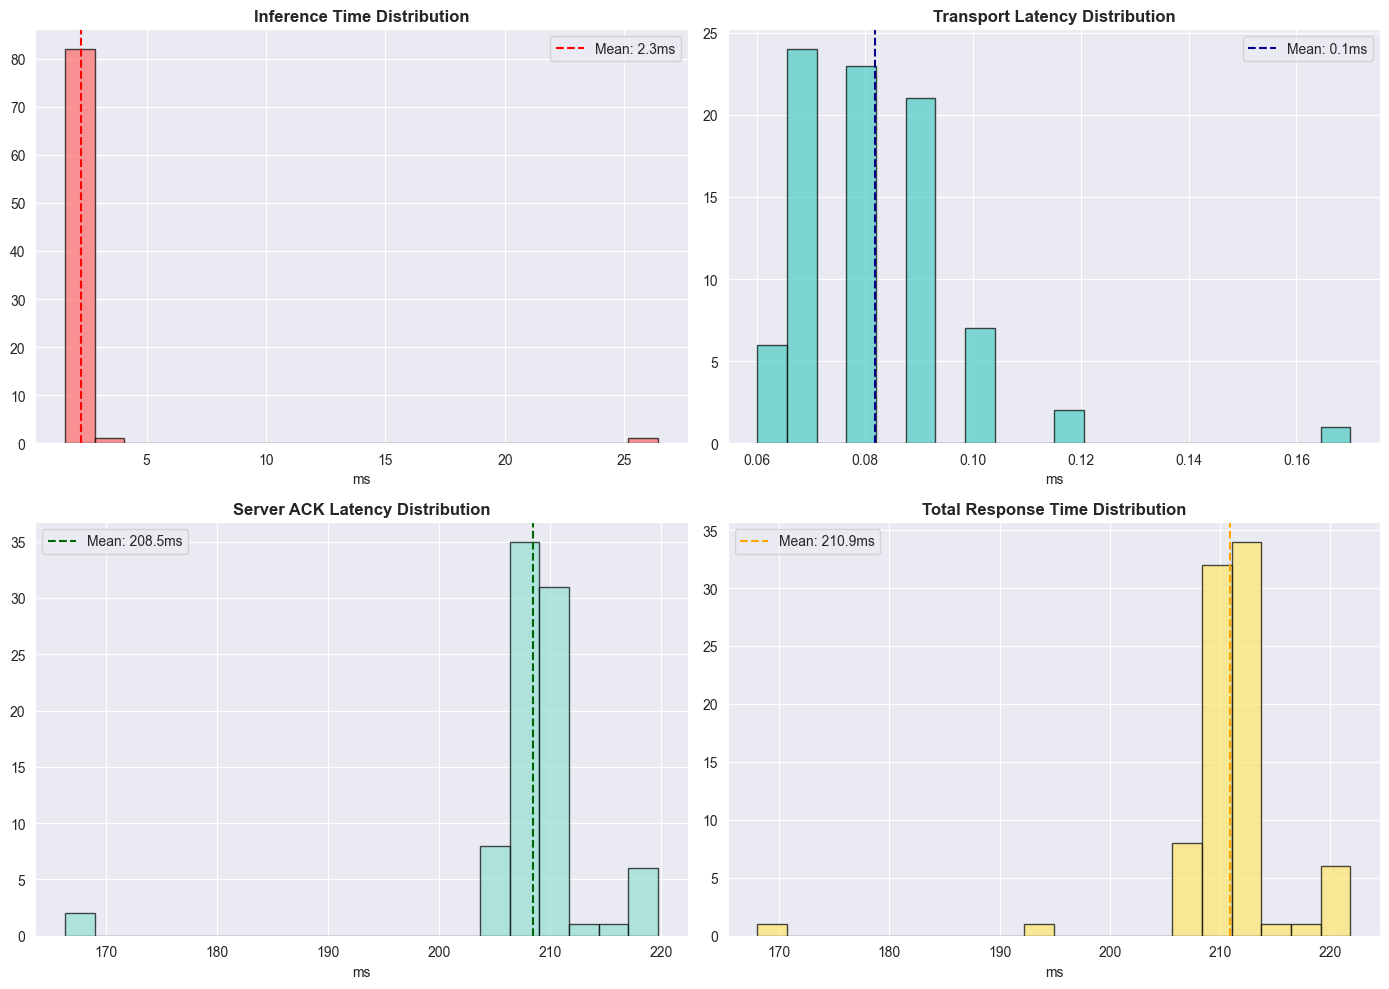

✅ Saved: latency_distribution.png


In [19]:
if len(committed) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Inference Time
    axes[0, 0].hist(committed['Inference Time (ms)'], bins=20, color='#FF6B6B', alpha=0.7, edgecolor='black')
    axes[0, 0].set_title('Inference Time Distribution', fontsize=12, fontweight='bold')
    axes[0, 0].set_xlabel('ms')
    axes[0, 0].axvline(committed['Inference Time (ms)'].mean(), color='red', linestyle='--', label=f"Mean: {committed['Inference Time (ms)'].mean():.1f}ms")
    axes[0, 0].legend()
    
    # Transport Latency
    axes[0, 1].hist(committed['Transport Latency (ms)'], bins=20, color='#4ECDC4', alpha=0.7, edgecolor='black')
    axes[0, 1].set_title('Transport Latency Distribution', fontsize=12, fontweight='bold')
    axes[0, 1].set_xlabel('ms')
    axes[0, 1].axvline(committed['Transport Latency (ms)'].mean(), color='darkblue', linestyle='--', label=f"Mean: {committed['Transport Latency (ms)'].mean():.1f}ms")
    axes[0, 1].legend()
    
    # ACK Latency
    axes[1, 0].hist(committed['Server ACK Latency (ms)'], bins=20, color='#95E1D3', alpha=0.7, edgecolor='black')
    axes[1, 0].set_title('Server ACK Latency Distribution', fontsize=12, fontweight='bold')
    axes[1, 0].set_xlabel('ms')
    axes[1, 0].axvline(committed['Server ACK Latency (ms)'].mean(), color='darkgreen', linestyle='--', label=f"Mean: {committed['Server ACK Latency (ms)'].mean():.1f}ms")
    axes[1, 0].legend()
    
    # Total Response Time
    axes[1, 1].hist(committed['Total Response Time (ms)'], bins=20, color='#FFE66D', alpha=0.7, edgecolor='black')
    axes[1, 1].set_title('Total Response Time Distribution', fontsize=12, fontweight='bold')
    axes[1, 1].set_xlabel('ms')
    axes[1, 1].axvline(committed['Total Response Time (ms)'].mean(), color='orange', linestyle='--', label=f"Mean: {committed['Total Response Time (ms)'].mean():.1f}ms")
    axes[1, 1].legend()
    
    plt.tight_layout()
    plt.savefig('latency_distribution.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("✅ Saved: latency_distribution.png")

## 4. Accuracy Analysis (Manual Label vs Prediction)

In [20]:
if len(committed) > 0:
    # Prepare data for accuracy metrics
    # Extract class from prediction (e.g., "left(0.95)" -> "left")
    def extract_class(pred_str):
        if isinstance(pred_str, str) and '(' in pred_str:
            return pred_str.split('(')[0].strip().lower()
        return str(pred_str).lower().strip()
    
    committed_copy = committed.copy()
    committed_copy['Predicted_Class'] = committed_copy['Prediksi Model'].apply(extract_class)
    
    # For manual labels, assume user fills them (if empty, skip accuracy)
    manual_labels_filled = committed_copy['Perintah Suara (Label - Manual)'].notna() & (committed_copy['Perintah Suara (Label - Manual)'] != '')
    
    if manual_labels_filled.sum() > 0:
        labeled_data = committed_copy[manual_labels_filled].copy()
        labeled_data['Manual_Class'] = labeled_data['Perintah Suara (Label - Manual)'].apply(lambda x: str(x).lower().strip())
        
        # Compute accuracy
        accuracy = accuracy_score(labeled_data['Manual_Class'], labeled_data['Predicted_Class'])
        print(f"✅ Accuracy (on manually labeled): {accuracy*100:.1f}% ({labeled_data['Predicted_Class'].eq(labeled_data['Manual_Class']).sum()}/{len(labeled_data)})")
        print(f"\n📋 Classification Report:\n")
        print(classification_report(labeled_data['Manual_Class'], labeled_data['Predicted_Class'], zero_division=0))
        
        # Confusion matrix
        classes = sorted(set(labeled_data['Manual_Class']).union(set(labeled_data['Predicted_Class'])))
        cm = confusion_matrix(labeled_data['Manual_Class'], labeled_data['Predicted_Class'], labels=classes)
        
        fig, ax = plt.subplots(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes, ax=ax, cbar_kws={'label': 'Count'})
        ax.set_title('Confusion Matrix (Actual vs Predicted)', fontsize=14, fontweight='bold')
        ax.set_ylabel('Actual', fontsize=12)
        ax.set_xlabel('Predicted', fontsize=12)
        plt.tight_layout()
        plt.savefig('confusion_matrix.png', dpi=150, bbox_inches='tight')
        plt.show()
        print("✅ Saved: confusion_matrix.png")
    else:
        print("⚠️  No manual labels filled yet. Fill 'Perintah Suara (Label - Manual)' column to compute accuracy.")
        print(f"\nPredicted classes distribution:")
        print(committed_copy['Predicted_Class'].value_counts())

⚠️  No manual labels filled yet. Fill 'Perintah Suara (Label - Manual)' column to compute accuracy.

Predicted classes distribution:
Predicted_Class
up       32
right    19
left     17
down     16
Name: count, dtype: int64


## 5. Confidence Score Analysis

📊 Confidence Statistics (Committed predictions):

Mean: 0.937
Median: 0.990
Std: 0.090
Min: 0.640
Max: 1.000


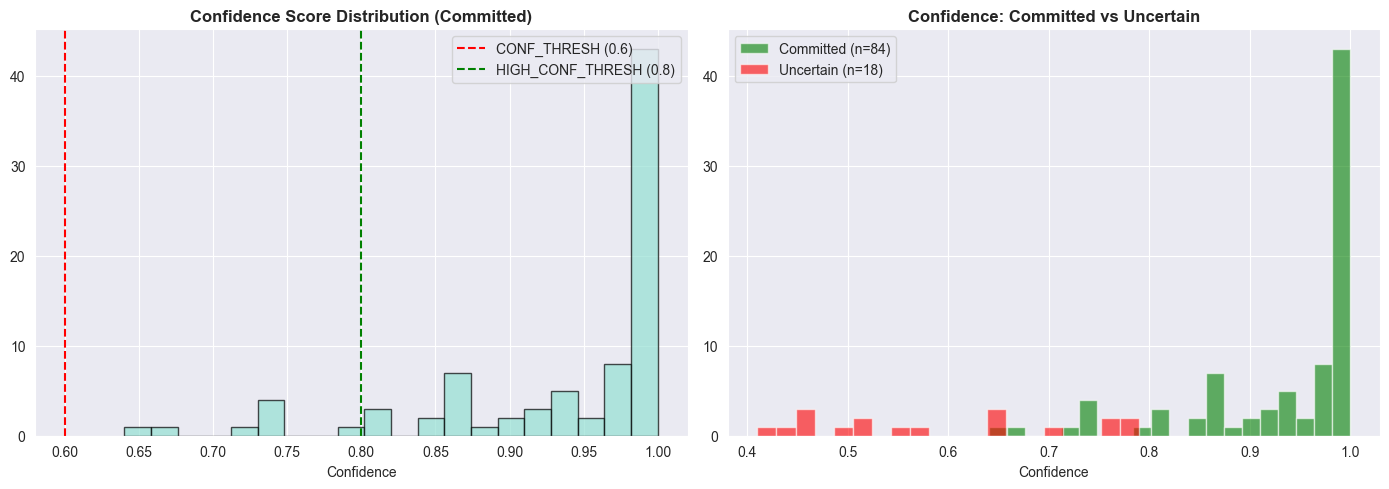

✅ Saved: confidence_analysis.png


In [21]:
if len(committed) > 0:
    # Extract confidence from prediction string
    def extract_confidence(pred_str):
        if isinstance(pred_str, str) and '(' in pred_str and ')' in pred_str:
            try:
                conf_str = pred_str.split('(')[1].split(')')[0]
                return float(conf_str)
            except:
                return None
        return None
    
    committed_copy['Extracted_Confidence'] = committed_copy['Prediksi Model'].apply(extract_confidence)
    
    # Compare with CSV Confidence column
    print("📊 Confidence Statistics (Committed predictions):")
    print(f"\nMean: {committed['Confidence'].mean():.3f}")
    print(f"Median: {committed['Confidence'].median():.3f}")
    print(f"Std: {committed['Confidence'].std():.3f}")
    print(f"Min: {committed['Confidence'].min():.3f}")
    print(f"Max: {committed['Confidence'].max():.3f}")
    
    # Confidence distribution
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    axes[0].hist(committed['Confidence'], bins=20, color='#95E1D3', alpha=0.7, edgecolor='black')
    axes[0].set_title('Confidence Score Distribution (Committed)', fontsize=12, fontweight='bold')
    axes[0].set_xlabel('Confidence')
    axes[0].axvline(0.6, color='red', linestyle='--', label='CONF_THRESH (0.6)')
    axes[0].axvline(0.8, color='green', linestyle='--', label='HIGH_CONF_THRESH (0.8)')
    axes[0].legend()
    
    # Compare committed vs uncertain confidence
    if len(uncertain) > 0:
        axes[1].hist(committed['Confidence'], bins=20, alpha=0.6, label=f'Committed (n={len(committed)})', color='green')
        axes[1].hist(uncertain['Confidence'], bins=20, alpha=0.6, label=f'Uncertain (n={len(uncertain)})', color='red')
        axes[1].set_title('Confidence: Committed vs Uncertain', fontsize=12, fontweight='bold')
        axes[1].set_xlabel('Confidence')
        axes[1].legend()
    
    plt.tight_layout()
    plt.savefig('confidence_analysis.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("✅ Saved: confidence_analysis.png")

## 6. Decision Filter Effectiveness

In [22]:
if len(df) > 0:
    print("🎯 Decision Filter Metrics:\n")
    
    committed = df[df['Prediksi Model'] != 'Uncertain']
    uncertain = df[df['Prediksi Model'] == 'Uncertain']
    
    total = len(df)
    commit_rate = len(committed) / total * 100
    uncertain_rate = len(uncertain) / total * 100
    
    print(f"Commit Rate: {commit_rate:.1f}% ({len(committed)}/{total})")
    print(f"Uncertain Rate: {uncertain_rate:.1f}% ({len(uncertain)}/{total})")
    
    # Analysis
    if commit_rate > 80:
        print("\n✅ Thresholds are PERMISSIVE (high confidence in decisions)")
        print("   → Risk: May include false positives")
        print("   → Action: Increase CONF_THRESH or TOP2_MARGIN_MIN to filter more")
    elif commit_rate < 30:
        print("\n⚠️  Thresholds are TOO STRICT (rejecting too many)")
        print("   → Risk: User frustration (too many uncertain)")
        print("   → Action: Decrease thresholds to allow more commits")
    else:
        print("\n✅ Thresholds are BALANCED")
    
    # If we have accuracy data, show correlation
    if len(committed) > 0:
        print(f"\nAverage confidence (committed): {committed['Confidence'].mean():.3f}")
        print(f"Average confidence (uncertain): {uncertain['Confidence'].mean() if len(uncertain) > 0 else 'N/A'}")

🎯 Decision Filter Metrics:

Commit Rate: 82.4% (84/102)
Uncertain Rate: 17.6% (18/102)

✅ Thresholds are PERMISSIVE (high confidence in decisions)
   → Risk: May include false positives
   → Action: Increase CONF_THRESH or TOP2_MARGIN_MIN to filter more

Average confidence (committed): 0.937
Average confidence (uncertain): 0.5883333333333334


## 7. Per-Class Performance

📊 Per-Class Statistics (Committed predictions):


DOWN:
  Count: 16
  Avg Confidence: 0.958
  Avg Inference Time: 1.95 ms
  Avg Total Response: 212.57 ms

LEFT:
  Count: 17
  Avg Confidence: 0.871
  Avg Inference Time: 1.94 ms
  Avg Total Response: 211.13 ms

RIGHT:
  Count: 19
  Avg Confidence: 0.935
  Avg Inference Time: 1.93 ms
  Avg Total Response: 211.79 ms

UP:
  Count: 32
  Avg Confidence: 0.962
  Avg Inference Time: 2.77 ms
  Avg Total Response: 209.29 ms


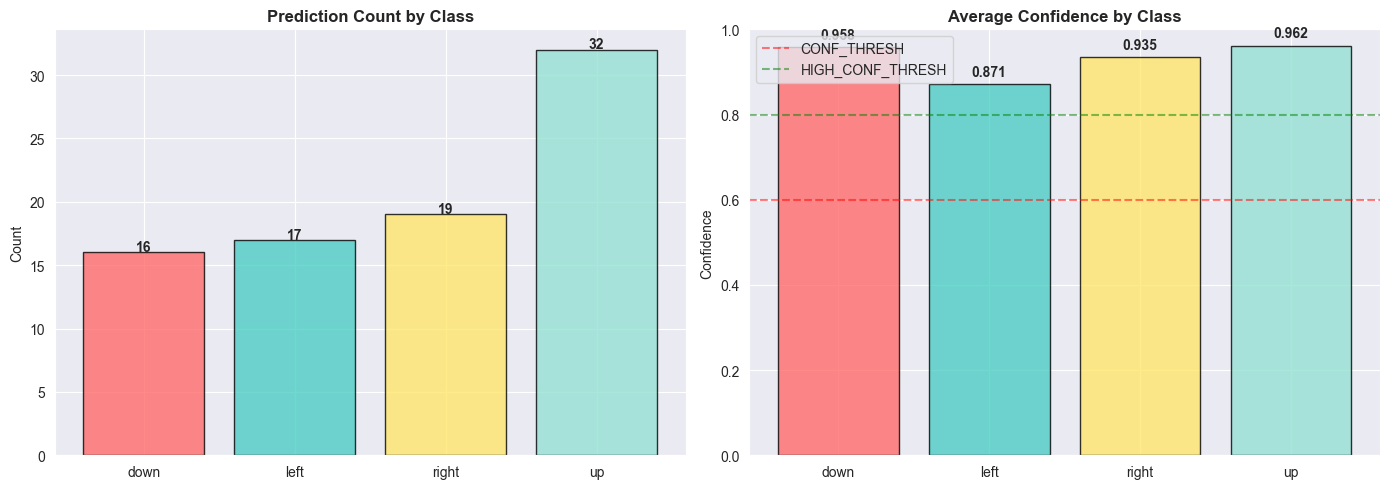


✅ Saved: per_class_performance.png


In [23]:
if len(committed) > 0:
    # Extract class
    committed_copy = committed.copy()
    committed_copy['Predicted_Class'] = committed_copy['Prediksi Model'].apply(extract_class)
    
    print("📊 Per-Class Statistics (Committed predictions):\n")
    
    for cls in ['down', 'left', 'right', 'up']:
        class_data = committed_copy[committed_copy['Predicted_Class'] == cls]
        if len(class_data) > 0:
            print(f"\n{cls.upper()}:")
            print(f"  Count: {len(class_data)}")
            print(f"  Avg Confidence: {class_data['Confidence'].mean():.3f}")
            print(f"  Avg Inference Time: {class_data['Inference Time (ms)'].mean():.2f} ms")
            print(f"  Avg Total Response: {class_data['Total Response Time (ms)'].mean():.2f} ms")
    
    # Visualization
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Count by class
    class_counts = committed_copy['Predicted_Class'].value_counts().reindex(['down', 'left', 'right', 'up'], fill_value=0)
    axes[0].bar(class_counts.index, class_counts.values, color=['#FF6B6B', '#4ECDC4', '#FFE66D', '#95E1D3'], alpha=0.8, edgecolor='black')
    axes[0].set_title('Prediction Count by Class', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('Count')
    for i, v in enumerate(class_counts.values):
        axes[0].text(i, v + 0.1, str(int(v)), ha='center', fontweight='bold')
    
    # Avg confidence by class
    class_conf = committed_copy.groupby('Predicted_Class')['Confidence'].mean().reindex(['down', 'left', 'right', 'up'], fill_value=0)
    axes[1].bar(class_conf.index, class_conf.values, color=['#FF6B6B', '#4ECDC4', '#FFE66D', '#95E1D3'], alpha=0.8, edgecolor='black')
    axes[1].set_title('Average Confidence by Class', fontsize=12, fontweight='bold')
    axes[1].set_ylabel('Confidence')
    axes[1].set_ylim([0, 1.0])
    axes[1].axhline(0.6, color='red', linestyle='--', alpha=0.5, label='CONF_THRESH')
    axes[1].axhline(0.8, color='green', linestyle='--', alpha=0.5, label='HIGH_CONF_THRESH')
    axes[1].legend()
    for i, v in enumerate(class_conf.values):
        if v > 0:
            axes[1].text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('per_class_performance.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("\n✅ Saved: per_class_performance.png")

## 8. Recommendations

In [24]:
print("""
╔════════════════════════════════════════════════════════════╗
║          THRESHOLD TUNING RECOMMENDATIONS                  ║
╚════════════════════════════════════════════════════════════╝

📌 INFERENCE TIME:
   - Target: < 100 ms for real-time feel
   - If > 200 ms: Consider using BiLSTM instead (might be faster)
   - If < 20 ms: Good! Bottleneck is elsewhere

📌 TRANSPORT LATENCY:
   - Typical TCP: 1-5 ms (local network)
   - If > 50 ms: Network issue (check server/game load)

📌 ACK LATENCY:
   - If 0 ms: Server may not be sending ACK, or timeout too short
   - If > 100 ms: Server processing slow or game window unresponsive

📌 CONFIDENCE THRESHOLD (CONF_THRESH):
   Current: 0.6
   - If accuracy < 80% & commit_rate > 70%: INCREASE to 0.65-0.70
   - If accuracy > 90% & commit_rate < 40%: DECREASE to 0.50
   - If uncertain_rate > 50%: TOO STRICT, decrease threshold

📌 HIGH CONFIDENCE THRESHOLD (HIGH_CONF_THRESH):
   Current: 0.8
   - This auto-commits regardless of margin (good for speed)
   - If false positives increase: INCREASE to 0.85-0.90

📌 TOP-2 MARGIN (TOP2_MARGIN_MIN):
   Current: 0.15
   - Small margin (< 0.10): More uncertain cases, slower response
   - Large margin (> 0.20): Stricter filtering, more uncertain
   - Recommendation: Keep at 0.15 unless accuracy is bad

📌 COOLDOWN (COOLDOWN_SECONDS):
   Current: 0.8 s
   - If duplicates still occur: INCREASE to 1.0-1.2 s
   - If response feels too slow: DECREASE to 0.5 s

📌 AGREEMENT WINDOW (AGREE_WINDOW):
   Current: 3 predictions
   - Larger (5): More stable, slower response
   - Smaller (2): Faster, less stable

╔════════════════════════════════════════════════════════════╗
║                    NEXT STEPS                               ║
╚════════════════════════════════════════════════════════════╝

1. ✅ Run inference_gui.py and speak 20-30 commands
2. ✅ Manually fill 'Perintah Suara (Label - Manual)' column for accuracy
3. ✅ Re-run this notebook to see real metrics
4. ✅ Test with game "Aing Kasep.exe" to verify game response
5. 🔧 Adjust thresholds based on:
   - Accuracy (too low? increase confidence threshold)
   - Duplicates (too many? increase cooldown)
   - Uncertain rate (too high? decrease confidence threshold)
6. 📊 Repeat analysis after each tuning

""")


╔════════════════════════════════════════════════════════════╗
║          THRESHOLD TUNING RECOMMENDATIONS                  ║
╚════════════════════════════════════════════════════════════╝

📌 INFERENCE TIME:
   - Target: < 100 ms for real-time feel
   - If > 200 ms: Consider using BiLSTM instead (might be faster)
   - If < 20 ms: Good! Bottleneck is elsewhere

📌 TRANSPORT LATENCY:
   - Typical TCP: 1-5 ms (local network)
   - If > 50 ms: Network issue (check server/game load)

📌 ACK LATENCY:
   - If 0 ms: Server may not be sending ACK, or timeout too short
   - If > 100 ms: Server processing slow or game window unresponsive

📌 CONFIDENCE THRESHOLD (CONF_THRESH):
   Current: 0.6
   - If accuracy < 80% & commit_rate > 70%: INCREASE to 0.65-0.70
   - If accuracy > 90% & commit_rate < 40%: DECREASE to 0.50
   - If uncertain_rate > 50%: TOO STRICT, decrease threshold

📌 HIGH CONFIDENCE THRESHOLD (HIGH_CONF_THRESH):
   Current: 0.8
   - This auto-commits regardless of margin (good for speed